In [2]:
# from abc import ABCMeta, abstractmethod

import copy
import heapq
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import re
import seaborn as sns
#import sknn
import sys
import time
# import torch
# import torch.nn as nn
# import torch.nn.functional as fn
import traceback
import tsfresh as tsf

from concurrent.futures import ThreadPoolExecutor
from scipy.stats import  ttest_ind
from multiprocessing import cpu_count
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, ExtraTreesClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RationalQuadratic, Exponentiation, RBF
from sklearn.kernel_approximation import RBFSampler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.manifold import Isomap
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures, QuantileTransformer, PowerTransformer
from sklearn.svm import SVR, SVC, LinearSVC, LinearSVR
#from sknn.ae import AutoEncoder, Layer
from tqdm import tqdm
# from torch.utils.data import DataLoader
# from sklearn.gaussian_process import GaussianProcessRegressor
#from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
# pay attention to that, the iterative Imputer is not stable

# load data

In [3]:
def load_data(path, num):
    df1 = pd.read_csv(path, sep = '\t', header=None)
    df1.columns = ['time', 'Pw', 'distance']
    df1['sensor_nr'] = num
    df1 = df1.dropna() #filter
    #df1 = df1.fillna(method = 'backfill')
    df1 = df1[df1['distance'] < 20]
    df1 = df1[((df1['Pw'] < 50)&(df1['distance'] <10)).map(lambda x: not x)]
    return df1

In [4]:
df = []
fns = [i for i in os.listdir('data') if 'distance' in i]
fns

['sensor8_RC_w_distance_03.csv',
 'sensor8_RC_w_distance_04.csv',
 'sensor8_RC_w_distance_05.csv',
 'sensor8_RC_w_distance_06.csv',
 'sensor8_RC_w_distance_07.csv',
 'sensor8_RC_w_distance_08.csv',
 'sensor8_RC_w_distance_09.csv']

In [5]:
for i, j in enumerate(fns):
    print(j)
    df.append(load_data('data/' + j, i))
    df[i] = df[i].reset_index(drop=True)

sensor8_RC_w_distance_03.csv
sensor8_RC_w_distance_04.csv
sensor8_RC_w_distance_05.csv
sensor8_RC_w_distance_06.csv
sensor8_RC_w_distance_07.csv
sensor8_RC_w_distance_08.csv
sensor8_RC_w_distance_09.csv


In [6]:
df[1]

,time,Pw,distance,sensor_nr
0,2122,160.0,5.0,1
1,2192,202.0,3.0,1
2,2222,226.0,3.0,1
3,2251,253.0,3.0,1
4,2281,274.0,2.0,1
...,...,...,...,...
2025,82587,70.0,1.0,1
2026,82617,62.0,1.0,1
2027,82647,63.0,1.0,1
2028,82676,55.0,1.0,1


# Filter

In [6]:
# from scipy import signal

In [7]:
# b, a = signal.butter(8, 0.8, 'lowpass') 

In [8]:
# for i in df:
#     i['Pw'] = signal.filtfilt(b, a, i['Pw'])

In [9]:
# df[0]

In [10]:
# train_model(df[0])

# build model

## Simple model

In [7]:
def train_model(df):
    #df = df[['Pw', 'sensor_nr', 'distance']]
    ln = RandomForestRegressor()
#    ln = SVR()
    X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df.iloc[:, -1])
    ln.fit(X_train, y_train)
    pred = ln.predict(X_test)
    return np.mean(abs(pred - y_test)), ln

In [12]:
# for i in df:
#     print(train_model(i)[0])

# pickle

In [37]:
pickle.dump(model, open('data/svr.m', 'wb'))
m = pickle.load(open('data/svr.m', 'rb'))
# m.score(X_test, y_test)
# pred = m.predict(X_test)

## Time series prediction

In [13]:
df2 = df[2]

In [14]:
df2['time'] = df2['time'].astype(float)

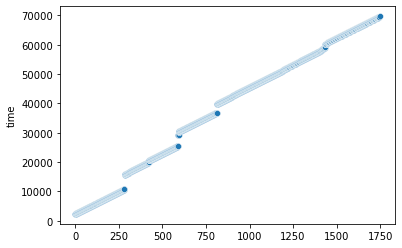

In [15]:
sns.scatterplot(x = range(len(df2)), y = df2['time'])

In [16]:
for i in range(200):
    df2['Pw_s'+str(i)] = df2['Pw'].shift(i)

In [17]:
df2 = df2.fillna(method='bfill')

In [18]:
df2.columns

Index(['time', 'Pw', 'distance', 'sensor_nr', 'Pw_s0', 'Pw_s1', 'Pw_s2',
       'Pw_s3', 'Pw_s4', 'Pw_s5',
       ...
       'Pw_s190', 'Pw_s191', 'Pw_s192', 'Pw_s193', 'Pw_s194', 'Pw_s195',
       'Pw_s196', 'Pw_s197', 'Pw_s198', 'Pw_s199'],
      dtype='object', length=204)

In [19]:
cols = list(df2.columns)[4:]
cols = [cols[i-1] for i in np.arange(len(cols), 0, -1)]
# cols.append('ae')
cols.append('distance')

In [20]:
# ae = np.arange(len(df2))
# for i in range(len(df2)):
#     ae[i] = tsf.feature_extraction.feature_calculators.has_duplicate(df2.iloc[i,:])

In [21]:
# ae = pd.Series(ae)
# df2['ae'] = ae
df2 = df2[cols]

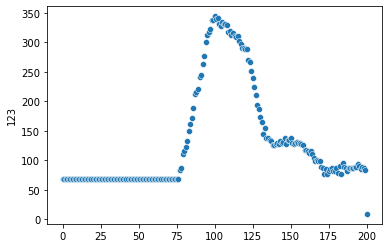

In [22]:
 sns.scatterplot(y = df2.iloc[123, :], x = range(len(cols)))

In [23]:
for i in range(10):
    reward, model = train_model(df2.iloc[len(cols):, :])
    print(reward)

0.5788630490956073
0.6499741602067184
0.5742635658914729
0.5713953488372093
0.5803100775193798
0.5771576227390182
0.6068217054263566
0.6037726098191215
0.5557364341085271
0.5910594315245478


In [24]:
df2.tail(20)

,Pw_s199,Pw_s198,Pw_s197,Pw_s196,Pw_s195,Pw_s194,Pw_s193,Pw_s192,Pw_s191,Pw_s190,...,Pw_s8,Pw_s7,Pw_s6,Pw_s5,Pw_s4,Pw_s3,Pw_s2,Pw_s1,Pw_s0,distance
1728,73.0,64.0,63.0,68.0,70.0,68.0,70.0,62.0,67.0,69.0,...,339.0,333.0,340.0,339.0,344.0,344.0,344.0,341.0,340.0,2.0
1729,64.0,63.0,68.0,70.0,68.0,70.0,62.0,67.0,69.0,75.0,...,333.0,340.0,339.0,344.0,344.0,344.0,341.0,340.0,333.0,2.0
1730,63.0,68.0,70.0,68.0,70.0,62.0,67.0,69.0,75.0,72.0,...,340.0,339.0,344.0,344.0,344.0,341.0,340.0,333.0,334.0,2.0
1731,68.0,70.0,68.0,70.0,62.0,67.0,69.0,75.0,72.0,68.0,...,339.0,344.0,344.0,344.0,341.0,340.0,333.0,334.0,330.0,2.0
1732,70.0,68.0,70.0,62.0,67.0,69.0,75.0,72.0,68.0,73.0,...,344.0,344.0,344.0,341.0,340.0,333.0,334.0,330.0,317.0,2.0
1733,68.0,70.0,62.0,67.0,69.0,75.0,72.0,68.0,73.0,77.0,...,344.0,344.0,341.0,340.0,333.0,334.0,330.0,317.0,306.0,2.0
1734,70.0,62.0,67.0,69.0,75.0,72.0,68.0,73.0,77.0,75.0,...,344.0,341.0,340.0,333.0,334.0,330.0,317.0,306.0,307.0,3.0
1735,62.0,67.0,69.0,75.0,72.0,68.0,73.0,77.0,75.0,80.0,...,341.0,340.0,333.0,334.0,330.0,317.0,306.0,307.0,294.0,3.0
1736,67.0,69.0,75.0,72.0,68.0,73.0,77.0,75.0,80.0,80.0,...,340.0,333.0,334.0,330.0,317.0,306.0,307.0,294.0,295.0,3.0
1737,69.0,75.0,72.0,68.0,73.0,77.0,75.0,80.0,80.0,80.0,...,333.0,334.0,330.0,317.0,306.0,307.0,294.0,295.0,286.0,2.0


In [18]:
pickle.dump(model, open('data/svr.m', 'wb'))
m = pickle.load(open('data/svr.m', 'rb'))
# m.score(X_test, y_test)
# pred = m.predict(X_test)

In [29]:
df2.iloc[100,:-1].reshape(1,-1)

AttributeError: 'Series' object has no attribute 'reshape'

In [27]:
a.reshape(1,-1)

AttributeError: 'Series' object has no attribute 'reshape'

In [22]:
pred = m.predict(df2.iloc[:,:-1])

In [23]:
pred

array([10.86, 10.66, 10.29, ...,  4.28,  4.27,  9.73])

# Plot

In [26]:
df1.head()

NameError: name 'df1' is not defined

In [ ]:
import seaborn as sns

In [ ]:
sns.scatterplot(y = df[0]['distance'], x = df[0]['Pw'])

In [ ]:
sns.scatterplot(x = range(len(df[0])), y = df[0]['Pw'])
sns.scatterplot(x = range(len(df[0])), y = df[0]['distance'])

In [ ]:
sns.scatterplot(x = range(len(df[0])), y = df[0]['distance'])

In [ ]:
df[0]

In [31]:
pw12 = np.zeros(50,1)

TypeError: data type not understood

In [24]:
pw12[1] = 3

In [25]:
pw12

array([0., 3., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [29]:
pw12 = pw12.transpose()

In [34]:
pw12 = pw12.reshape(1,50)

In [36]:
pw12.shape

(1, 50)